# KNN baseline for Azure VM criticality

This notebook trains a K-Nearest Neighbors classifier using **arrival-time-safe** features only (static config + tenant history + request time).

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    f1_score,
    precision_recall_curve,
)

# Paths
DATA_DIR = Path("../data_final")
TRAIN_PATH = DATA_DIR / "vm_train.parquet"
VAL_PATH = DATA_DIR / "vm_val.parquet"
TEST_PATH = DATA_DIR / "vm_test.parquet"
TARGET_COL = "critical"

In [2]:
# 1) Load data splits
print("Loading split files...")
df_train = pl.read_parquet(TRAIN_PATH)
df_val = pl.read_parquet(VAL_PATH)
df_test = pl.read_parquet(TEST_PATH)

print(f"Train rows: {df_train.height}")

Loading split files...
Train rows: 632426


In [3]:
# 2) Arrival-time-safe feature list
# -----------------------------------------------------------------------------
# Timing
feat_timing = [
    "day_idx",
    "hour_of_day",
    "ts_vm_created",
    "ts_first_vm_created",
]

# Static VM config & deployment metadata
feat_static = [
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour",
]

# Tenant history (safe) derived only from earlier VMs
feat_history = [c for c in df_train.columns if c.startswith("hist_")]

# Categorical
feat_categorical = ["vm_category"]

SAFE_NUMERIC_COLS = feat_timing + feat_static + feat_history
SAFE_CATEGORICAL_COLS = feat_categorical
ALL_SAFE_FEATURES = SAFE_NUMERIC_COLS + SAFE_CATEGORICAL_COLS

print(f"Total features: {len(ALL_SAFE_FEATURES)}")

Total features: 23


In [4]:
# 3) Prepare X/y helper
def get_X_y(df_polars):
    X = df_polars.select(ALL_SAFE_FEATURES).to_pandas()
    y = df_polars.select(TARGET_COL).to_pandas().values.ravel()
    return X, y

X_train, y_train = get_X_y(df_train)
X_val, y_val = get_X_y(df_val)
X_test, y_test = get_X_y(df_test)

In [5]:
# 4) Preprocess + model pipeline
# -----------------------------------------------------------------------------
# KNN is distance-based, so scaling numeric columns is essential.
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, SAFE_NUMERIC_COLS),
        ("cat", categorical_transformer, SAFE_CATEGORICAL_COLS),
    ]
)

# Baseline KNN (can tune neighbors/weights/metric later)
knn = KNeighborsClassifier(
    n_neighbors=50,
    weights="distance",  # distance weighting often helps with class imbalance
    metric="minkowski",
    p=2,
    n_jobs=-1,
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", knn),
    ]
)

Training KNN...
Done.

--- Validation (threshold=0.200) ---
              precision    recall  f1-score   support

           0      0.979     0.959     0.969    126056
           1      0.205     0.338     0.255      3949

    accuracy                          0.940    130005
   macro avg      0.592     0.648     0.612    130005
weighted avg      0.955     0.940     0.947    130005

ROC AUC: 0.8352
PR AUC:  0.1765
Confusion matrix:
 [[120879   5177]
 [  2616   1333]]


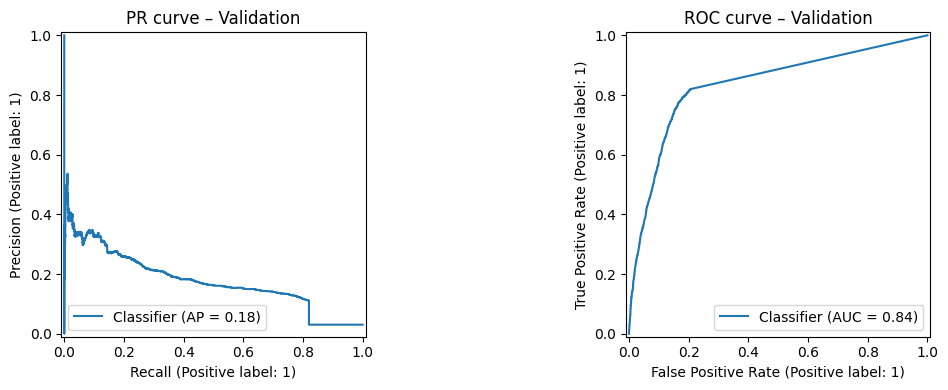


--- Test (threshold=0.200) ---
              precision    recall  f1-score   support

           0      0.984     0.950     0.967    128977
           1      0.118     0.298     0.169      2872

    accuracy                          0.936    131849
   macro avg      0.551     0.624     0.568    131849
weighted avg      0.965     0.936     0.949    131849

ROC AUC: 0.8170
PR AUC:  0.1000
Confusion matrix:
 [[122550   6427]
 [  2016    856]]


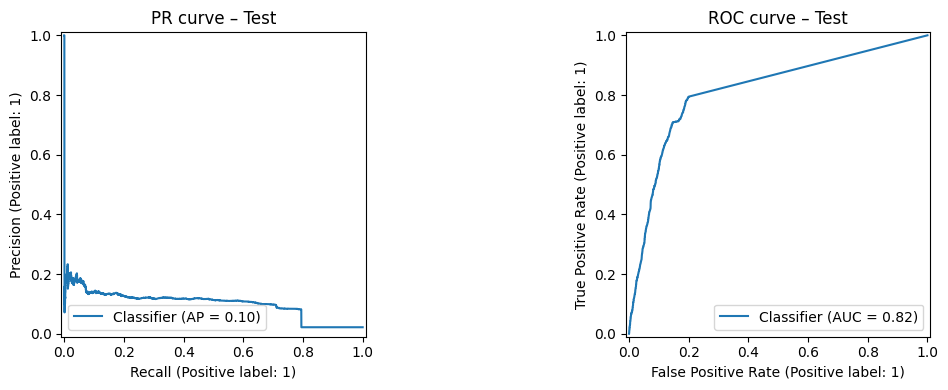

In [6]:
# 5) Train and evaluate (aligned with RF notebook output)
# -----------------------------------------------------------------------------
print("Training KNN...")
model.fit(X_train, y_train)
print("Done.")

def evaluate_split(model, X, y, split_name: str, threshold: float = 0.5) -> dict:
    """Print metrics (report, ROC AUC, PR AUC, confusion) and return them."""
    proba = model.predict_proba(X)[:, 1]
    preds = (proba >= threshold).astype(int)

    auc_pr = average_precision_score(y, proba)
    auc_roc = roc_auc_score(y, proba)
    cm = confusion_matrix(y, preds)

    print(f"\n--- {split_name} (threshold={threshold:.3f}) ---")
    print(classification_report(y, preds, digits=3, zero_division=0))
    print(f"ROC AUC: {auc_roc:.4f}")
    print(f"PR AUC:  {auc_pr:.4f}")
    print("Confusion matrix:\n", cm)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    PrecisionRecallDisplay.from_predictions(y, proba, ax=axes[0])
    axes[0].set_title(f"PR curve – {split_name}")
    RocCurveDisplay.from_predictions(y, proba, ax=axes[1])
    axes[1].set_title(f"ROC curve – {split_name}")
    plt.tight_layout()
    plt.show()

    return {"auc_pr": auc_pr, "auc_roc": auc_roc, "confusion": cm.tolist()}

# Tune a threshold on val (F1) to mirror RF notebook
proba_val = model.predict_proba(X_val)[:, 1]
candidates = np.linspace(0.01, 0.5, 200)
best_threshold = max(candidates, key=lambda t: f1_score(y_val, (proba_val >= t).astype(int)))

# Optional: get the PR curve arrays too
prec, rec, pr_thresholds = precision_recall_curve(y_val, proba_val)

metrics_val = evaluate_split(model, X_val, y_val, "Validation", threshold=best_threshold)
metrics_test = evaluate_split(model, X_test, y_test, "Test", threshold=best_threshold)
